In [1]:
import torch
import os
print(torch.__version__)

import torch.nn as nn

import torchvision
from torchvision import datasets

import matplotlib.pyplot as plt
%matplotlib inline

from models import VariationalAutoEncoderCelebA
from tqdm.auto import tqdm
import numpy as np

import pandas as pd

from PIL import Image

from utils import output_to_pil

1.7.0


In [2]:
def load_image(path):
    img = Image.open(path)
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor()
    ])
    return transform(img)


class Dataset:
    def __init__(self, path_to_jpg):
        self.path = path_to_jpg
        self.filenames = os.listdir(path_to_jpg)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        return load_image(self.path + '/' + self.filenames[item])

In [3]:
data = Dataset("../data/celeba/img_align_celeba/img_align_celeba")
train, valid = torch.utils.data.random_split(data, [int(0.8*len(data)), len(data)-int(0.8*len(data))])

In [4]:
model = VariationalAutoEncoderCelebA(3, 200, 3).to("cuda")
reconstruction_loss_fn = nn.MSELoss().to("cuda")
kl_loss_fn = lambda mu, log_var: -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False)
kl_factor = 1e-5

In [5]:
for epoch in range(10):

    train_loss = 0
    valid_loss = 0

    model.train()
    for images in tqdm(dataloader, leave=False):
        optimizer.zero_grad()
        mu, log_var, output = model(images.to("cuda"))
        reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
        kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
        loss = reconstruction_loss + kl_factor * kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(dataloader)

    model.eval()
    with torch.no_grad():
        for images in tqdm(valid_loader, leave=False):
            mu, log_var, output = model(images.to("cuda"))
            reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
            kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
            loss = reconstruction_loss + kl_factor * kl_loss
            valid_loss += loss.item() / len(valid_loader)

    print(f"Epoch {epoch+1}: train_loss {train_loss}, valid_loss {valid_loss}")

Epoch 1: train_loss 0.021966342979753348, valid_loss 0.01399846492834657
Epoch 2: train_loss 0.016133548220415468, valid_loss 0.013136783169267688
Epoch 3: train_loss 0.01497933942445818, valid_loss 0.012602270052103822
Epoch 4: train_loss 0.014301387756246479, valid_loss 0.012388082864158323
Epoch 5: train_loss 0.013915029164451458, valid_loss 0.012629062113253821


KeyboardInterrupt: 

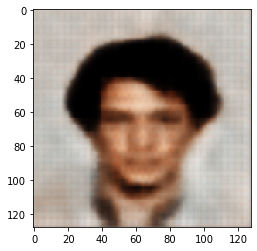

In [12]:
plt.imshow(model.decoder(torch.randn(1, 200).cpu().detach().squeeze(0).permute(1,2,0));
